# Описание проекта. Телеком
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.  

## Описание услуг
Оператор предоставляет два основных типа услуг:
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
Также абонентам доступен ряд услуг:
Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
Выделенная линия технической поддержки (Tech Support);
Облачное хранилище файлов для резервного копирования данных (Online Backup);
Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.  

## Описание данных
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.  

**Таблица telecom.contract**
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.  

**Таблица personal**
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.  

**Таблица telecom.internet**
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.  

**Таблица telecom.phone**
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.  

Информация о договорах актуальна на 1 февраля 2020.

# Загрузим данные

In [1]:
# установим более старую версию sqlalchemy, чтобы избежать ошибок
!pip install --force-reinstall 'sqlalchemy<2.0.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.2/613.2 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: greenlet
    Found existing installation: greenlet 3.0.1
    Uninstalling greenlet-3.0.1:
      Successfully uninstalled greenlet-3.0.1
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.


## Импортируем библиотеки

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.2 MB/s eta 0:00:00


In [3]:
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 5.9 MB/s eta 0:00:00


In [4]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 2.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import phik
import lightgbm as lgb
from skorch import NeuralNetBinaryClassifier
from torch.nn import ReLU, Sigmoid
from torch.optim import SGD
from torch.nn import BCELoss
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve,\
    roc_auc_score, RocCurveDisplay, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sqlalchemy import create_engine, text
from dateutil.relativedelta import relativedelta
from catboost import CatBoostClassifier
from sklearn.utils import shuffle

In [6]:
# введем константы
RANDOM_STATE = 50723

## Настроим конфигурацию для подключения к базе данных

In [7]:
db_config = {
    'user': 'praktikum_student',# имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp',# пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения,
    'db': 'data-science-final'# название базы данных,
    }

In [8]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [9]:
# создадим подключение
engine = create_engine(connection_string)

# Загрузим данные

In [10]:
# создадим функцию для отображения информации о данных
def first_look(df):
    display(df.head())
    display(df.describe())
    print(df.info())

In [11]:
# загрузим данные с информацией о договорах
query = '''
SELECT *
FROM telecom.contract;
'''

contract = pd.read_sql_query(query, con=engine)

first_look(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


В таблице с контрактами 7043 строки,  
дубликаты отсутствуют,  
пропуски есть в столбце с общими расходами у пользователей, которые подключены первый месяц


In [12]:
# загрузим данные с информацией о клиентах
query = '''
SELECT *
FROM telecom.personal;
'''

personal = pd.read_sql_query(query, con=engine)

first_look(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


В данных о клиентах 7043 строки, что соответсвует количеству контрактов, пропуски отсутствуют

In [13]:
# загрузим данные с информацией об интернет услугах
query = '''
SELECT *
FROM telecom.internet;
'''

internet = pd.read_sql_query(query, con=engine)

internet.columns = internet.iloc[0]
internet = internet.reindex(internet.index.drop(0))

first_look(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


В данных об интернет услугах 5517 строк, пропуски отсутствуют

In [14]:
# загрузим данные с информацией об услугах телефонии.
query = '''
SELECT *
FROM telecom.phone;
'''

phone = pd.read_sql_query(query, con=engine)

phone.columns = phone.iloc[0]
phone = phone.reindex(phone.index.drop(0))

first_look(phone)

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


В данных об услугах телефонии 6361 строка, пропуски отсутствуют

**Выводы:**  
Нам предоставлены данные о 7043 клиентах.  
1869 клиентов перестали пользоваться услугами оператора связи.  
В данных есть пропуски в суммарном количестве трат у новых клиентов (которые пользуются услугами оператора первый месяц).  
5517 клиентов пользуется услугами по предоставлению интернета.

# Объединим данные

In [15]:
big_df = personal.merge(contract, on=['customerID'])
big_df = big_df.merge(internet, how='left', on=['customerID'])
big_df = big_df.merge(phone, how='left', on=['customerID'])

In [16]:
first_look(big_df)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


,SeniorCitizen,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,0.162147,64.761692,2283.300441
std,0.368612,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,0.000000,35.500000,401.450000
50%,0.000000,70.350000,1397.475000
75%,0.000000,89.850000,3794.737500
max,1.000000,118.750000,8684.800000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


# Добавим столбец с длительностью контракта в днях

In [17]:
def day_space(df):
    if df['EndDate'] == None:
        delta = (datetime.date(2020, 2, 1) - df['BeginDate']).days
    else:
        delta = (df['EndDate'] - df['BeginDate']).days
    return delta

In [18]:
big_df['day_space'] = big_df.apply(day_space, axis=1)

In [19]:
big_df['day_space'].head()

0    278
1    312
2    479
3    406
4    279
Name: day_space, dtype: int64

In [20]:
big_df['day_space'].describe()

count    7043.000000
mean      297.378674
std        83.868181
min         0.000000
25%       242.000000
50%       298.000000
75%       351.000000
max       583.000000
Name: day_space, dtype: float64

In [21]:
big_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,day_space
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,...,29.85,DSL,No,Yes,No,No,No,No,NaN,278
1,5575-GNVDE,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,...,1889.50,DSL,Yes,No,Yes,No,No,No,No,312
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,108.15,DSL,Yes,Yes,No,No,No,No,No,479
3,7795-CFOCW,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),...,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN,406
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,...,151.65,Fiber optic,No,No,No,No,No,No,No,279


# Выделим целевой признак (окончание контракта)

In [22]:
def target_row(df):
    if df['EndDate'] == None:
        target = 0
    else:
        target = 1
    return target

In [23]:
big_df['target'] = big_df.apply(target_row, axis=1)

In [24]:
big_df['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

In [25]:
big_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,day_space,target
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,NaN,278,0
1,5575-GNVDE,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,312,0
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,479,1
3,7795-CFOCW,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),...,DSL,Yes,No,Yes,Yes,No,No,NaN,406,0
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,...,Fiber optic,No,No,No,No,No,No,No,279,1


In [26]:
# посмотрим общую информацию о получившемся наборе данных
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


# Заполним пропуски

In [27]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [28]:
#заполним пропуски TotalCharges нулями
big_df['TotalCharges'] = big_df['TotalCharges'].fillna(0)

In [29]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [30]:
# пропуски в MultipleLines заполним unknown
big_df['MultipleLines'] = big_df['MultipleLines'].fillna('unknown')

In [31]:
# оставшиеся пропуски заполним No
big_df = big_df.fillna('No')

In [32]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   float64
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [33]:
big_df.describe()

,SeniorCitizen,MonthlyCharges,TotalCharges,day_space,target
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,64.761692,2279.734304,297.378674,0.265370
std,0.368612,30.090047,2266.794470,83.868181,0.441561
min,0.000000,18.250000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,242.000000,0.000000
50%,0.000000,70.350000,1394.550000,298.000000,0.000000
75%,0.000000,89.850000,3786.600000,351.000000,1.000000
max,1.000000,118.750000,8684.800000,583.000000,1.000000


# Визуализируем распределения признаков

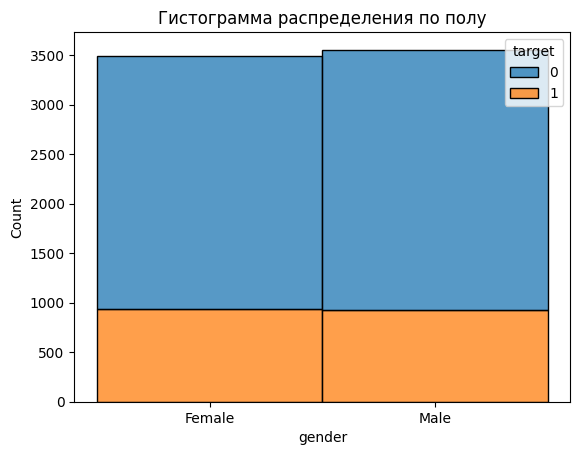

In [34]:
# построим гистограмму распределения по полу
sns.histplot(data=big_df, x='gender', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по полу')
print()

В наших данных количество мужчин и женщин примерно одинаково, количество ушедших от нас клиентов меньше половины в данных

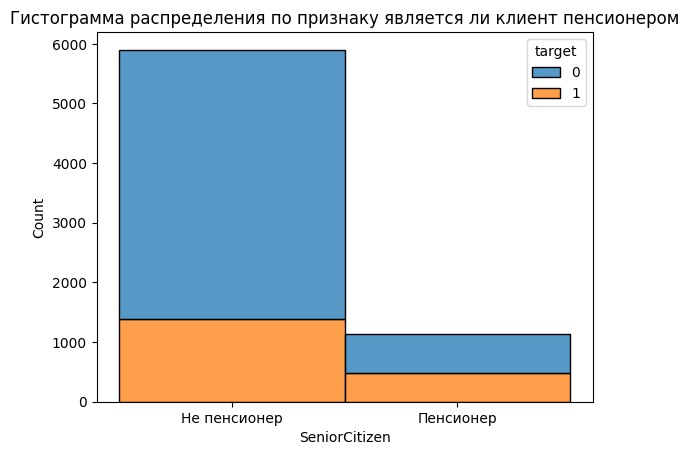

In [35]:
# построим гистограмму распределения по признаку является ли клиент пенсионером
sns.histplot(data=big_df, x='SeniorCitizen', hue='target', bins=2, discrete=True, multiple='stack').\
    set(title='Гистограмма распределения по признаку является ли клиент пенсионером')
plt.xticks([0, 1], ['Не пенсионер', 'Пенсионер'])
print()

Большинство клиентов не пенсионеры, среди не пенсионеров большинство остаются клиентами оператора, среди пенсионеров большинство прекратили быть клиентами

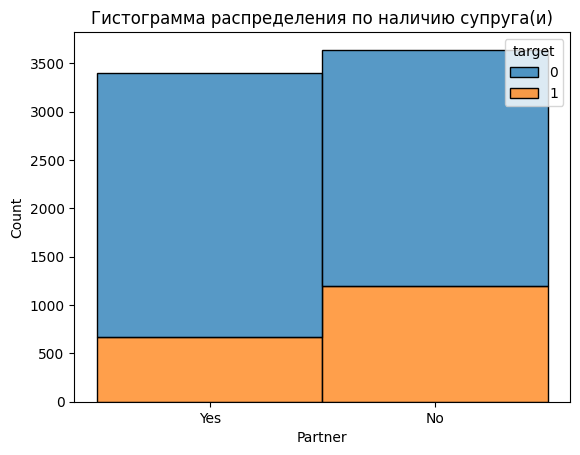

In [36]:
# построим гистограмму распределения по наличию супруга(и)
sns.histplot(data=big_df, x='Partner', hue='target', bins=2, discrete=True, multiple='stack').\
    set(title='Гистограмма распределения по наличию супруга(и)')
print()

Количество клиентов с супругами и без них примерно одинаково. Большинство клиентов без супругов остаются клиентами оператора. Количество клиентов

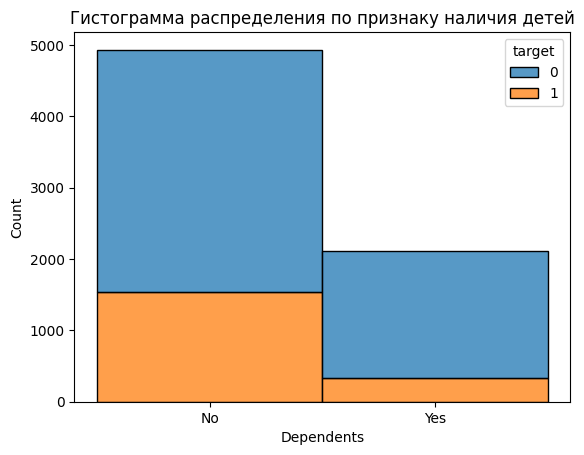

In [37]:
# построим гистограмму распределения по наличию детей
sns.histplot(data=big_df, x='Dependents', hue='target', discrete=True, multiple='stack').\
    set(title='Гистограмма распределения по признаку наличия детей')
print()

Большая часть клиентов не имеет детей. Большинство клиентов с детьми не уходят от оператора связи

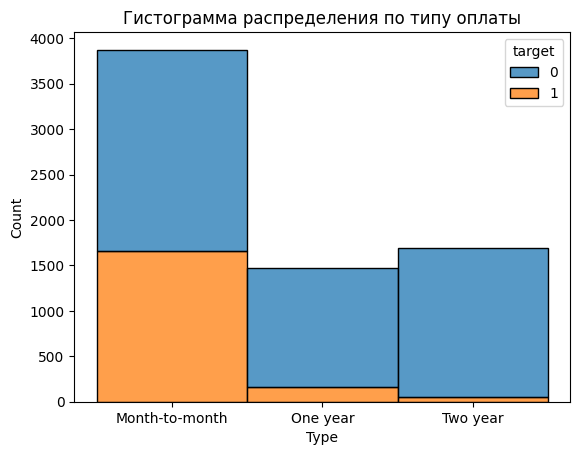

In [38]:
# построим гистограмму распределения по типу оплаты
sns.histplot(data=big_df, x='Type', hue='target', discrete=True, multiple='stack').\
    set(title='Гистограмма распределения по типу оплаты')
print()

Большинство клиентов пользуются ежемесячной оплаты, чуть меньше половины из них перестали пользоваться услугами оператора. Клиенты, пользующиеся оплатой раз в год или в два, перестают пользоваться услугами оператора значительно реже

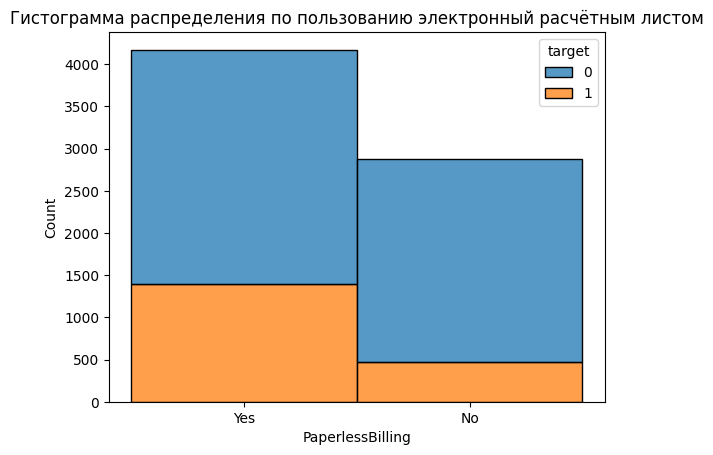

In [39]:
# построим гистограмму распределения по пользованию электронный расчётным листом
sns.histplot(data=big_df, x='PaperlessBilling', hue='target', discrete=True, multiple='stack').\
    set(title='Гистограмма распределения по пользованию электронный расчётным листом')
print()

Чуть больше половины клиентов пользуется электроннным расчётным листом. Доля ушедших клиентов среди пользователей, пользующихся бумажным расчётным листом сильно меньше

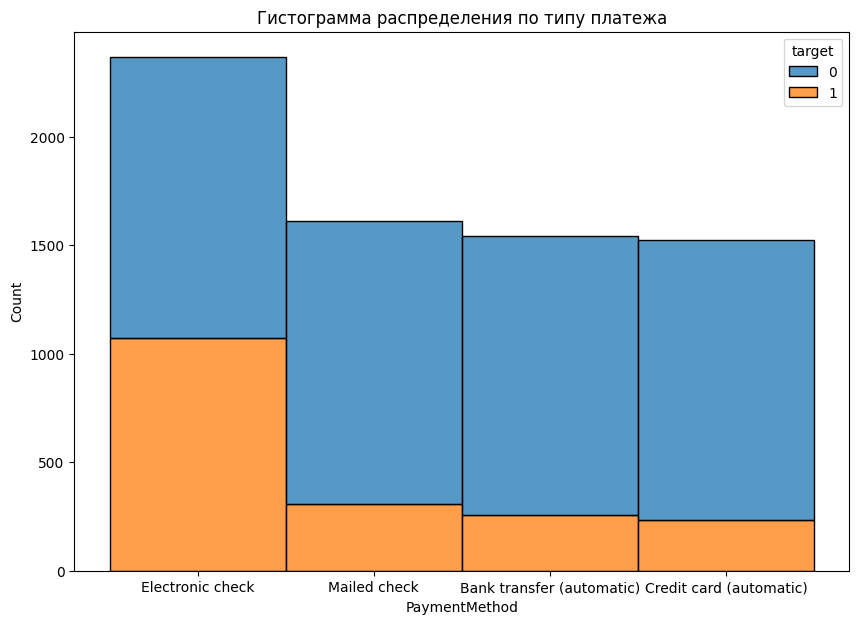

In [40]:
# построим гистограмму распределения по типу платежа
plt.figure(figsize=(10, 7))
sns.histplot(data=big_df, x='PaymentMethod', hue='target', discrete=True, multiple='stack').\
    set(title='Гистограмма распределения по типу платежа')

print()

Большинство клиентов пользуется электронными чеками, доля клиентов, которые перестали пользоваться услугами, в трех остальных категориях примерно одинаково

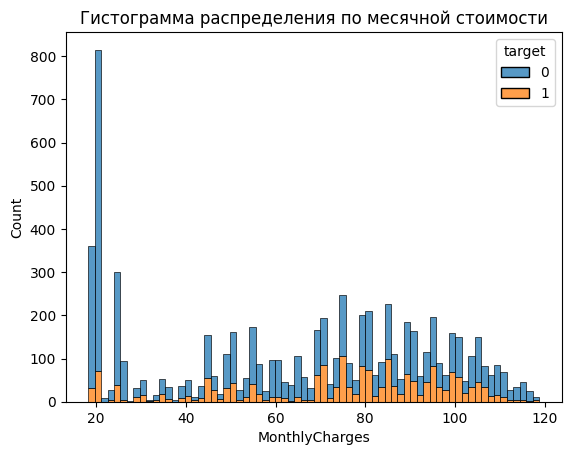

In [41]:
# построим гистограмму распределения по месячной стоимости
sns.histplot(data=big_df, bins=70, x='MonthlyCharges', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по месячной стоимости')

print()

Большинство пользователей платит около 20 у.е. в месяц

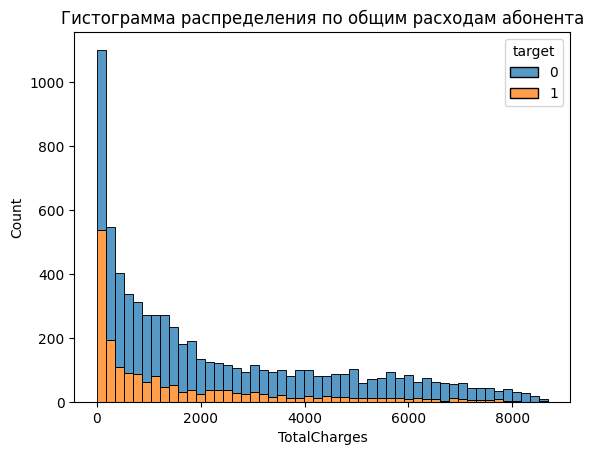

In [42]:
# построим гистограмму распределения по общим расходам абонента
sns.histplot(data=big_df, x='TotalCharges', bins=50, hue='target', multiple='stack').\
    set(title='Гистограмма распределения по общим расходам абонента')

print()

Большинство клиентов оттекают при небольших суммах платежей

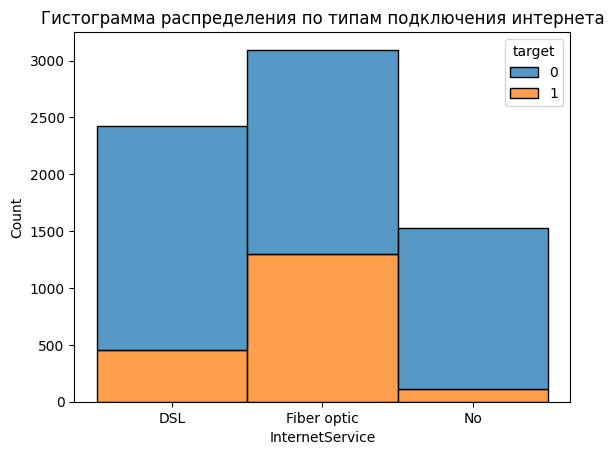

In [43]:
# построим гистограмму распределения по типам подключения интернета
sns.histplot(data=big_df, x='InternetService', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по типам подключения интернета')

print()

Большинство клиентов пользуются подключением по оптическому волокну, эти же клиенты наиболее часто перестают пользоваться услугами

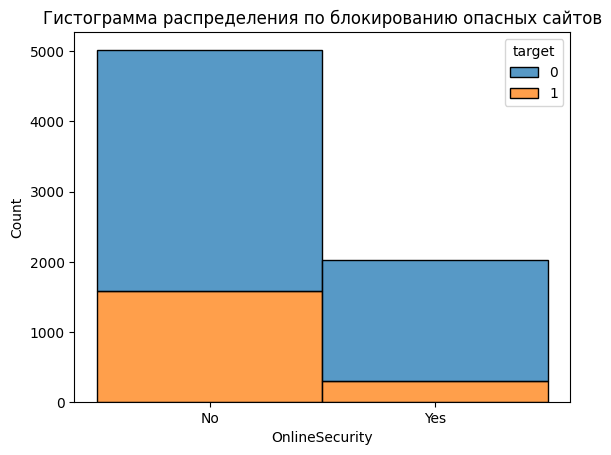

In [44]:
# построим гистограмму распределения по блокированию опасных сайтов
sns.histplot(data=big_df, x='OnlineSecurity', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по блокированию опасных сайтов')

print()

Большая часть клиентов не пользуется блокировкой сайтов

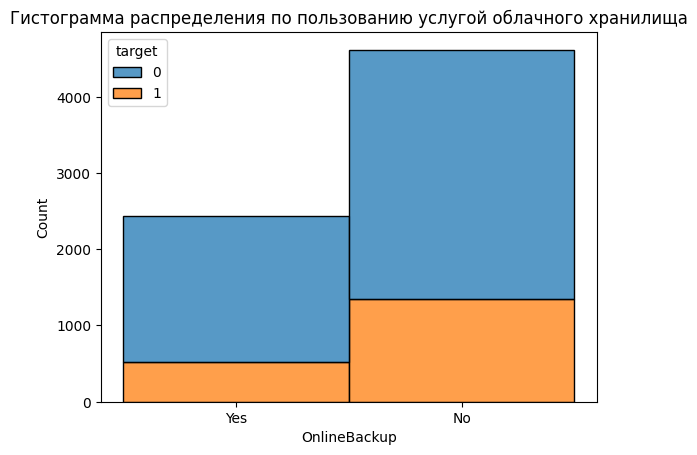

In [45]:
# построим гистограмму распределения по пользованию услугой облачного хранилища
sns.histplot(data=big_df, x='OnlineBackup', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по пользованию услугой облачного хранилища')

print()

Большинство пользователей не пользуются услугой облачного хранилища

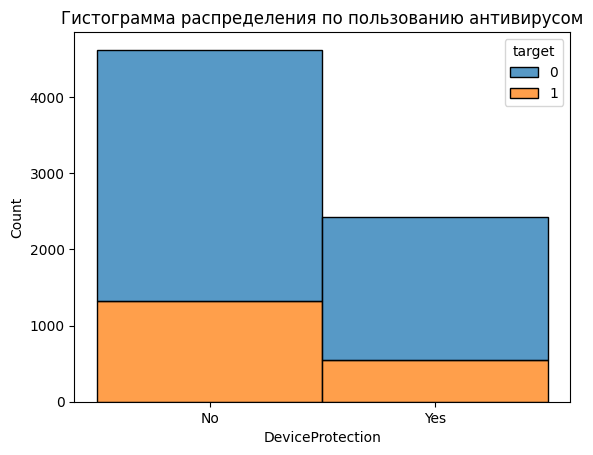

In [46]:
# построим гистограмму распределения по пользованию антивирусом
sns.histplot(data=big_df, x='DeviceProtection', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по пользованию антивирусом')

print()

Большая часть пользователей не пользуется антивирусом

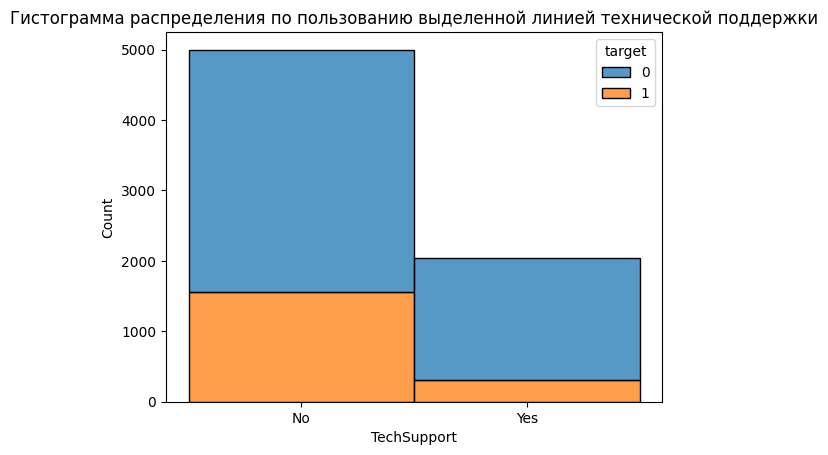

In [47]:
# построим гистограмму распределения по пользованию выделенной линией технической поддержки
sns.histplot(data=big_df, x='TechSupport', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по пользованию выделенной линией технической поддержки')

print()

Большая часть пользователей не пользуется выделенной линией технической поддержки

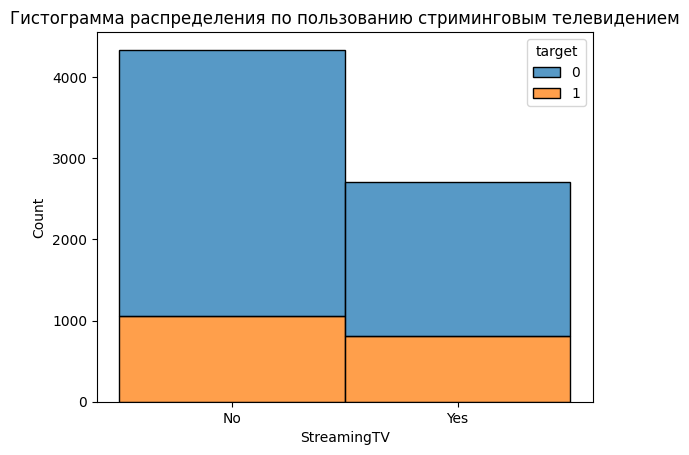

In [48]:
# построим гистограмму распределения по пользованию стриминговым телевидением
sns.histplot(data=big_df, x='StreamingTV', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по пользованию стриминговым телевидением')

print()

Большая часть пользователей не пользуется стриминговым телевидением

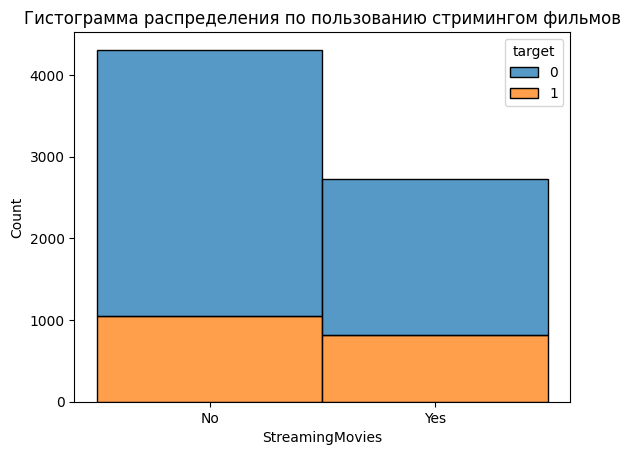

In [49]:
# построим гистограмму распределения по пользованию стримингом фильмов
sns.histplot(data=big_df, x='StreamingMovies', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по пользованию стримингом фильмов')

print()

Большая часть пользователей не пользуется стримингом фильмов

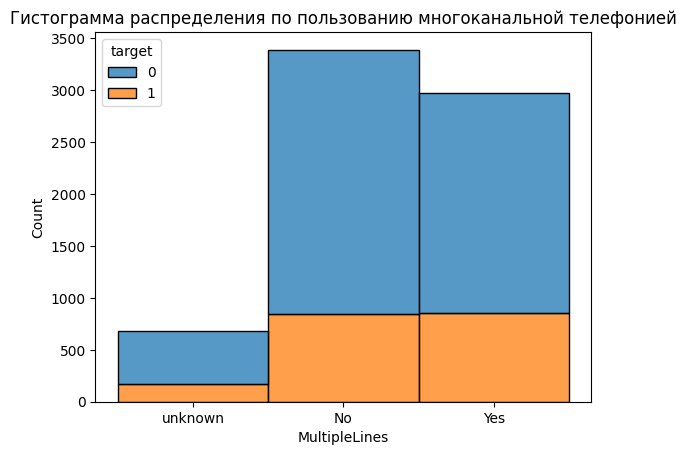

In [50]:
# построим гистограмму распределения по пользованию многоканальной телефонией
sns.histplot(data=big_df, x='MultipleLines', hue='target', multiple='stack').\
    set(title='Гистограмма распределения по пользованию многоканальной телефонией')

print()

Большая часть пользователей не пользуется многоканальной телефонией

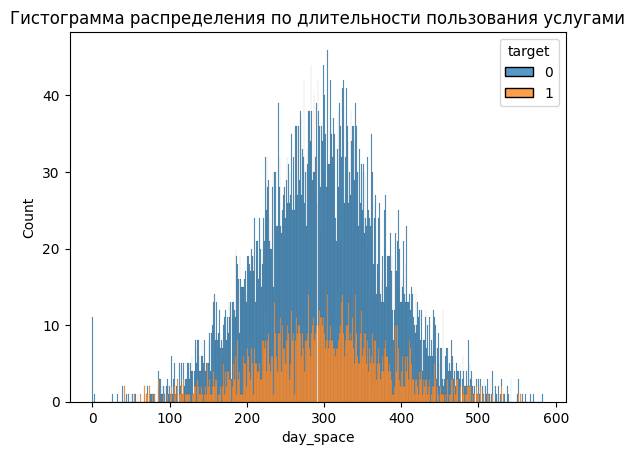

In [51]:
# построим гистограмму распределения по длительности пользования услугами
sns.histplot(data=big_df, x='day_space', discrete=True, hue='target', multiple='stack').\
    set(title='Гистограмма распределения по длительности пользования услугами')

print()

Большая часть пользователей подключена 250-350 дней, разспределение похоже на нормальное

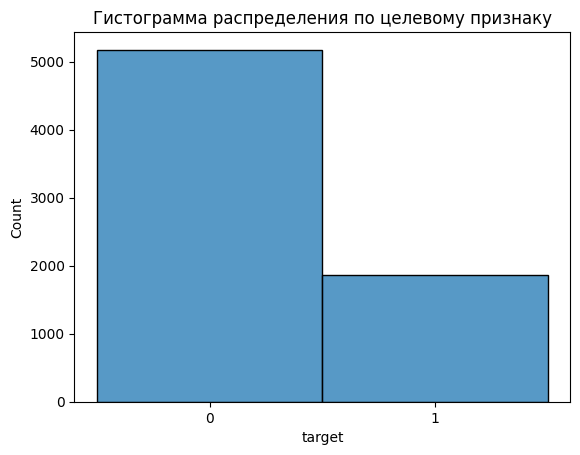

In [52]:
# построим гистограмму для определения баланса классов
sns.histplot(data=big_df, x='target', discrete=True).\
    set(title='Гистограмма распределения по целевому признаку')
plt.xticks([0, 1])
print()

В предоставленных данных наблюдается дисбаланс классов, большинство остаются клиентами оператора связи

interval columns not set, guessing: ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'day_space', 'target']



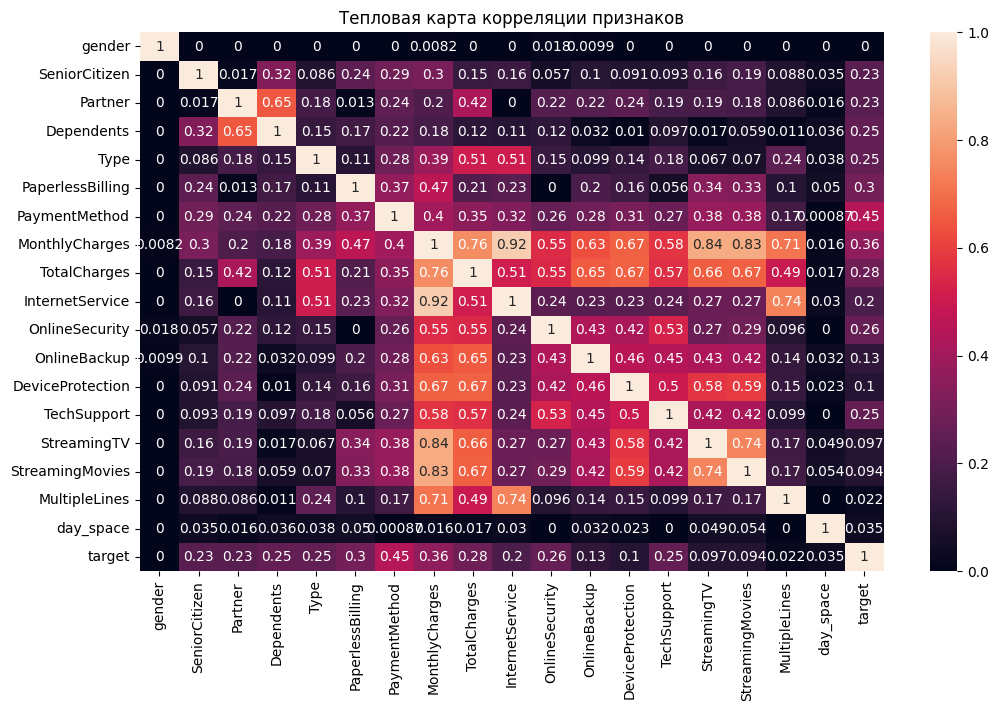

In [53]:
# потсроим тепловую карту корреляции признаков
fig = plt.figure(figsize=(12, 7))
sns.heatmap(big_df.drop(['customerID', 'EndDate', 'BeginDate'], axis=1).phik_matrix(), annot=True).\
    set(title='Тепловая карта корреляции признаков')

print()

Из тепловой карты видно, что сильно коррелируют следующие признаки:  
- наличие детей и супруга(и)
- суммарные траты и ежемесячные траты
- использование интернет услуг и месячные траты, что свидетельствует о высокой цене за интернет

# Итоговый  набор данных

Для анализа будем использовать все данные, кроме:
- Дата начала контракта
- Дата окончания контракта
- ID пользователя

In [54]:
final_df = big_df.drop(['BeginDate', 'customerID', 'EndDate'], axis=1)

In [55]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [56]:
# создадим список категориальных признаков
cat_features = ['gender',
            'SeniorCitizen',
            'Partner',
            'Dependents',
            'Type',
            'PaperlessBilling',
            'PaymentMethod',
            'InternetService',
            'OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV',
            'StreamingMovies',
            'MultipleLines'
            ]

In [57]:
# создадим список числовых признаков
num_features = ['MonthlyCharges', 'TotalCharges', 'day_space']

#Удалим выбросы

In [58]:
final_df_clean = final_df
for feature in num_features:
    final_df_clean = final_df_clean.loc[final_df_clean[feature] <= final_df_clean[feature].quantile(0.75) +
                              1.5 * (final_df_clean[feature].quantile(0.75) -
                                     final_df_clean[feature].quantile(0.25))]

# Разделим данные на тренировочные и тестовые

In [59]:
X = final_df_clean.drop(['target'], axis=1)
y = final_df_clean['target']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE,
                                                    stratify=y)

In [61]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5252, 18)
(1751, 18)
(5252,)
(1751,)


# Баланс классов

In [62]:
# сохраним отношение классов в константу
SCALE_POS_WEIGHT = y.value_counts()[0] / y.value_counts()[1]
print(SCALE_POS_WEIGHT)

2.7670790747713823


# Преобразуем данные методом OHE

In [63]:
ohe = OneHotEncoder(drop='first')

# преобразуем тренировочные данные
ohe.fit(X_train[cat_features])
ohe_train = ohe.transform(X_train[cat_features])
ohe_train_df = pd.DataFrame(ohe_train.toarray())
ohe_train_df.columns = ohe.get_feature_names_out()
X_train = X_train.reset_index(drop=True)
X_train_ohe = X_train.join(ohe_train_df)
X_train_ohe.drop(cat_features, axis = 1, inplace = True)
display(X_train_ohe.head())

,MonthlyCharges,TotalCharges,day_space,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MultipleLines_unknown
0,90.60,1660.00,487,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,19.85,19.85,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,85.20,2151.60,169,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,26.10,692.55,321,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,19.10,529.50,318,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Преобразуем тестовые данные
ohe_test = ohe.transform(X_test[cat_features])
ohe_test_df = pd.DataFrame(ohe_test.toarray())
ohe_test_df.columns = ohe.get_feature_names_out()
X_test = X_test.reset_index(drop=True)
X_test_ohe = X_test.join(ohe_test_df)
X_test_ohe.drop(cat_features, axis = 1, inplace = True)
display(X_test_ohe.head())

,MonthlyCharges,TotalCharges,day_space,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MultipleLines_unknown
0,102.60,4213.35,454,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,46.00,181.60,359,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,70.80,3478.15,368,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,104.70,7220.35,374,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
4,59.75,1374.35,314,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#Отмасштабируем признаки

In [65]:
ss = StandardScaler()

# преобразуем тренировочные данные
ss.fit_transform(X_train_ohe[num_features])
ss_train = ss.transform(X_train_ohe[num_features])
ss_train_df = pd.DataFrame(ss_train)
ss_train_df.columns = ss.get_feature_names_out()

X_train_ohe[num_features] = ss_train_df[num_features]
display(X_train_ohe.head())

,MonthlyCharges,TotalCharges,day_space,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MultipleLines_unknown
0,0.876820,-0.259951,2.361164,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.472545,-0.988018,-3.020233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.697505,-0.041729,-1.554818,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.265004,-0.689405,0.316972,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.497450,-0.761783,0.280029,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Преобразуем тестовые признаки
ss_test = ss.transform(X_test_ohe[num_features])
ss_test_df = pd.DataFrame(ss_test)
ss_test_df.columns = ss.get_feature_names_out()
X_test_ohe[num_features] = ss_test_df[num_features]
display(X_test_ohe.head())

,MonthlyCharges,TotalCharges,day_space,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MultipleLines_unknown
0,1.275299,0.873488,1.954788,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,-0.604193,-0.916217,0.784919,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.219330,0.547131,0.895749,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.345033,2.208303,0.969635,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
4,-0.147603,-0.386752,0.230771,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#Обучим различные модели

##RandomForest

In [67]:
%%time
rfc = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
params = {'n_estimators' : range(10, 1000, 10),
          'max_depth' : range(1, 100, 5),
          'min_samples_split' : range(2, 20),
          'min_samples_leaf' : range(1, 20)}
rscv_rfc = RandomizedSearchCV(rfc, params, scoring='roc_auc', random_state=RANDOM_STATE)
rscv_rfc.fit(X_train_ohe, y_train)
print(f'ROC-AUC = {rscv_rfc.best_score_}')
print(f'Параметры лучшей модели {rscv_rfc.best_estimator_}')

ROC-AUC = 0.845143868672299
Параметры лучшей модели RandomForestClassifier(class_weight='balanced', max_depth=21,
                       min_samples_leaf=11, min_samples_split=14,
                       n_estimators=980, random_state=50723)
CPU times: user 2min 1s, sys: 408 ms, total: 2min 2s
Wall time: 2min 21s


## CatBoostClassifier

In [68]:
%%time
cbc = CatBoostClassifier(logging_level='Silent',
                         random_state=RANDOM_STATE,
                         scale_pos_weight=SCALE_POS_WEIGHT,
                         cat_features=cat_features
                         )

params = {'n_estimators' : range(100, 1000, 200),
          'depth' : [2, 6, 18],
          'learning_rate' : [0.001, 0.01, 0.1]
          }
gscv_cbc = RandomizedSearchCV(cbc, params, scoring='roc_auc', random_state=RANDOM_STATE)
gscv_cbc.fit(X_train, y_train)
print(f'ROC-AUC = {gscv_cbc.best_score_}')
print(f'Параметры лучшей модели {gscv_cbc.best_params_}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    t

ROC-AUC = 0.8459175606814648
Параметры лучшей модели {'n_estimators': 900, 'learning_rate': 0.01, 'depth': 6}
CPU times: user 3min 51s, sys: 19.2 s, total: 4min 10s
Wall time: 3min


##LightGBM

In [69]:
%%time
lgbmc = lgb.LGBMClassifier(random_state=RANDOM_STATE,
                           class_weight='balanced',
                           objective='binary')
params={
        }

gscv_lgbmc = GridSearchCV(lgbmc, params, scoring='roc_auc')
gscv_lgbmc.fit(X_train_ohe, y_train)
print(f'ROC-AUC = {gscv_lgbmc.best_score_}')
print(f'Параметры лучшей модели {gscv_lgbmc.best_params_}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1115, number of negative: 3086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4201, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1115, number of negative: 3086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

## GradientBoost

In [70]:
%%time
model_gb = GradientBoostingClassifier()
params = {'n_estimators' : [1000, 2000, 3000],
          'learning_rate' : [0.01]
          }
rscv_gb = RandomizedSearchCV(model_gb, params, scoring='roc_auc', random_state=RANDOM_STATE)
rscv_gb.fit(X_train_ohe, y_train)
print(f'ROC-AUC = {rscv_gb.best_score_}')
print(f'Параметры лучшей модели {rscv_gb.best_params_}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ROC-AUC = 0.8425440051514647
Параметры лучшей модели {'n_estimators': 1000, 'learning_rate': 0.01}
CPU times: user 4min 28s, sys: 325 ms, total: 4min 29s
Wall time: 4min 30s


## Нейронная сеть

In [71]:
# добавим валидационную выборку
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train_ohe, y_train, test_size=0.25, random_state=RANDOM_STATE)

In [72]:
X_train_tens = torch.FloatTensor(X_train_s.values)
X_val_tens = torch.FloatTensor(X_val.values)
X_test_tens = torch.FloatTensor(X_test_ohe.values)
y_train_tens = torch.FloatTensor(y_train_s.values)
y_val_tens = torch.FloatTensor(y_val.values)
y_test_tens = torch.FloatTensor(y_test.values)

In [73]:
print(X_train_tens.shape)
print(X_val_tens.shape)
print(X_test_tens.shape)
print(y_train_tens.shape)
print(y_val_tens.shape)
print(y_test_tens.shape)

torch.Size([3939, 23])
torch.Size([1313, 23])
torch.Size([1751, 23])
torch.Size([3939])
torch.Size([1313])
torch.Size([1751])


In [74]:
class NeuralNet(nn.Module):

    def __init__(self, in_features=23, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=512)
        self.act1 = ReLU()
        self.fc2 = nn.Linear(in_features=512,
                             out_features=256)
        self.act2 = ReLU()
        self.output = nn.Linear(in_features=256,
                             out_features=out_features)
        self.act3 = nn.Sigmoid()

    def forward(self, X):
        X = self.fc1(X)
        X = self.act1(X)
        # Second hidden layer
        X = self.fc2(X)
        X = self.act2(X)
        # Third hidden layer
        X = self.output(X)
        X = self.act3(X)

        return X

In [75]:
model = NeuralNetBinaryClassifier(
    NeuralNet,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=200
)

In [76]:
model.fit(X_train_tens, y_train_tens)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6973       0.7348        0.6931  0.6081
      2        0.6931       0.7348        0.6931  0.4323
      3        0.6931       0.7348        0.6931  0.3782
      4        0.6931       0.7348        0.6931  0.3734
      5        0.6931       0.7348        0.6931  0.3803
      6        0.6931       0.7348        0.6931  0.3851
      7        0.6931       0.7348        0.6931  0.3501
      8        0.6931       0.7348        0.6931  0.3326
      9        0.6931       0.7348        0.6931  0.3383
     10        0.6931       0.7348        0.6931  0.3536
     11        0.6931       0.7348        0.6931  0.3812
     12        0.6931       0.7348        0.6931  0.3752
     13        0.6931       0.7348        0.6931  0.3711
     14        0.6931       0.7348        0.6931  0.4609
     15        0.6931       0.7348        0.6931  0.5012
     16        0.6931       0.7

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=NeuralNet(
    (fc1): Linear(in_features=23, out_features=512, bias=True)
    (act1): ReLU()
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (act2): ReLU()
    (output): Linear(in_features=256, out_features=1, bias=True)
    (act3): Sigmoid()
  ),
)

In [77]:
preds_val = model.predict(X_val_tens)

In [78]:
roc_auc_score(y_val_tens, preds_val)

0.5

Лучше всех себя показала модель CatBoostClassifier с параметрами n_estimators = 900, learning_rate = 0.01, depth = 6,  
**ROC-AUC = 0.845917**

# Лучшая модель
Наибольший результат показала модель CatBoostClassifier, протестируем её на тестовой выборке

In [79]:
%%time
best_model = CatBoostClassifier(learning_rate=0.01,
                                iterations=900,
                                depth=6,
                                logging_level='Silent',
                                cat_features=cat_features,
                                random_state=RANDOM_STATE,
                                scale_pos_weight=SCALE_POS_WEIGHT)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    best_model.fit(x_train_fold, y_train_fold)

pred_test = best_model.predict_proba(X_test)
# сохраняем вероятности только для положительного исхода
pred_test = pred_test[:, 1]
# рассчитываем ROC AUC
auc = roc_auc_score(y_test, pred_test)
print(f'ROC-AUC score = {auc}')

ROC-AUC score = 0.8480275589892808
CPU times: user 1min 4s, sys: 5.28 s, total: 1min 10s
Wall time: 44 s


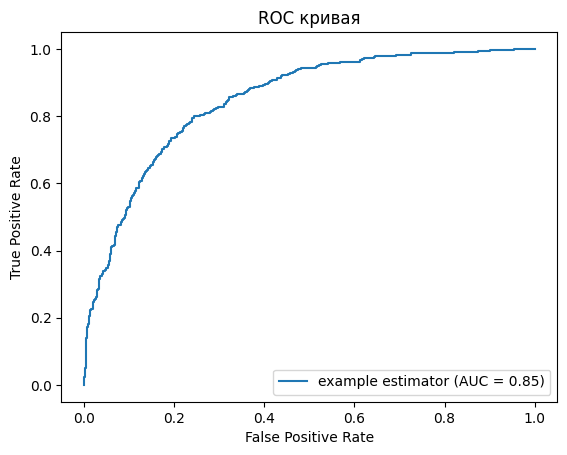

In [80]:
# построим график ROC кривой
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.title('ROC кривая')
plt.show()

In [81]:
y_pred = best_model.predict(X_test)

In [82]:
print(f'Точность = {accuracy_score(y_test, y_pred)}')

Точность = 0.7624214734437464


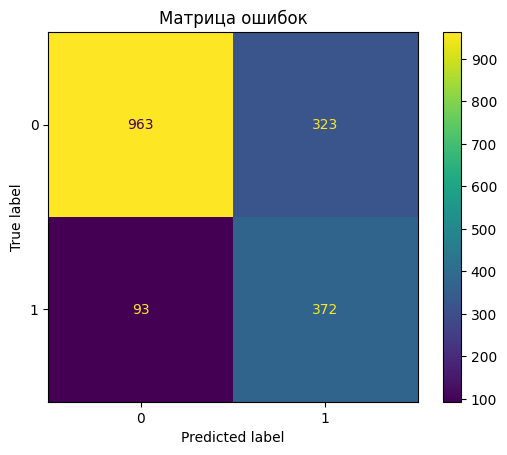

In [83]:
# построим матрицу ошибок
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
fig, ax = plt.subplots()

ax.set(title='Матрица ошибок')
display.plot(ax=ax);

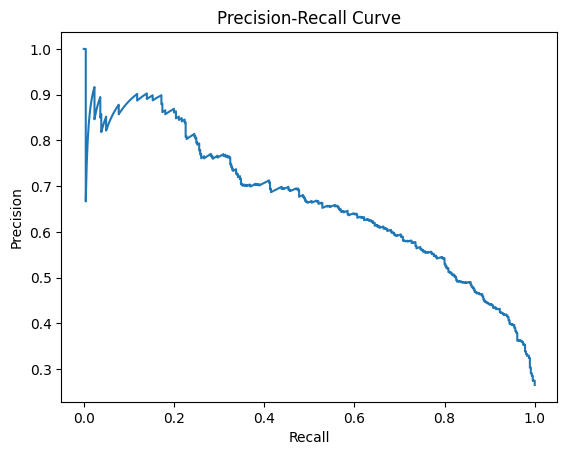

In [84]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_test)

fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

# Оценка важности признаков

In [85]:
best_model.feature_importances_

array([ 0.57032479,  1.08464663,  0.38209309,  0.8816047 , 25.3280161 ,
        2.30698368,  7.77258366,  5.34289941, 15.36852427, 17.17934556,
        1.40083033,  0.47864085,  0.21454895,  3.61308197,  2.52690609,
        2.53594672,  6.53177301,  6.48125017])

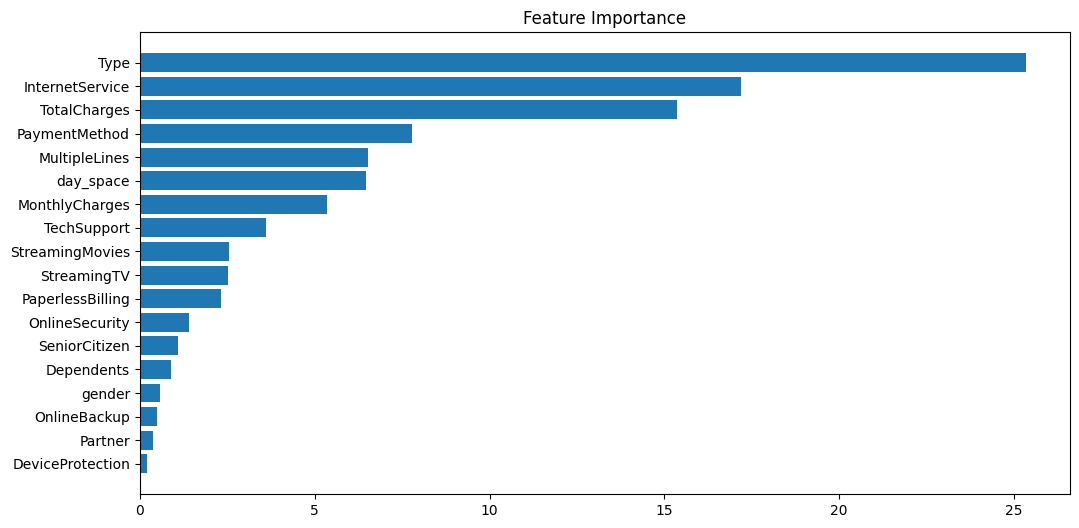

In [86]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

## Вывод:
Наиболее сильно влияют признаки:
- тип оплаты - клиенты, пользующиеся оплатой раз в два года или раз в год, выбрали оператора на долгосрочную перспективу и им сложнее сменить оператора, так как необходимо сменять оператора под конец оплаченного года
- пользование интернет-сервисами
- суммарные траты

# Общий вывод

В ходе проекта были загружены данные, была произведена предварительная обработка данных, был создан дополнительный признак показывающий траты пользователей в день в среднем.  
На итоговом наборе данных были обучены различные модели, а именно:  
- решающий лес
- CatBoost
- нейронная сеть.   

Лучший результат на тренировочной выборке показала модель CatBoost с параметрами  
*learning_rate = 0.01, iterations = 900, depth = 6*  

Эта модель на тестовой выборке показала результат  
*ROC_AUC = 0.848, Accuracy = 0.7624.*  

В результате анализ значений признаков было определено, что больше остальных влияют признаки - способа оплаты (по годам или раз в месяц) и пользование услугами интернета.

Рекомендации: Проанализировать причину оттока клиентов, пользующихся услугами интернета, вероятно плохая скорость или нестабильность подключения являются причинами